# Cross Validation of ML algorithms with simple data analysis

In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from matplotlib import colors as mcolors
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
import pandas as pd
import sklearn as sk
from xgboost import XGBClassifier
from sklearn.preprocessing.imputation import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
%matplotlib inline

/home/amadeusz/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Load and check training dataset  

 <b>mjd</b> - the time in Modified Julian Date (MJD) of the observation. 
       Can be read as days since November 17, 1858. Can be converted to Unix epoch time with the formula 
       unix_time = (MJD−40587)×86400. Float64

 <b>passband</b> - The specific LSST passband integer, such that u, g, r, i, z, Y = 0, 1, 2, 3, 4, 5 in which it was viewed. Int8
 
 <b>flux</b> - the measured flux (brightness) in the passband of observation as listed in the passband column. 
        These values have already been corrected for dust extinction (mwebv), though heavily extincted objects 
        will have larger uncertainties (flux_err) in spite of the correction. Float32

 <b>flux_err</b> -  the uncertainty on the measurement of the flux listed above. Float32

 <b>detected</b> - If 1, the object's brightness is significantly different at the 3-sigma level 
           relative to the reference template. Only objects with at least 2 detections are included in the dataset. Boolean

***Load training dataset.***

In [6]:
dataset = pd.read_csv("/media/amadeusz/78F69DA1F69D6064/Users/Amadeusz/Downloads/all/training_set.csv")
dataset.head()

,object_id,mjd,passband,flux,flux_err,detected
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


In [3]:
meta_dataset = pd.read_csv("/media/amadeusz/78F69DA1F69D6064/Users/Amadeusz/Downloads/all/training_set_metadata.csv")
column_names = {6: "class_6", 15: "class_15", 16: "class_16", 42: "class_42", 52: "class_52", 53: "class_53",
                62: "class_62", 64: "class_64", 65: "class_65", 67: "class_67", 88: "class_88", 90: "class_90",
                92: "class_92", 95: "class_95"}
meta_dataset["target"] = list(map(lambda name: column_names[name], meta_dataset["target"]))
meta_dataset.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,class_92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,class_88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,class_42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,class_90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,class_90


In [4]:
meta_dataset['in_our_galaxy'] = meta_dataset['distmod'].apply(np.isnan).astype(int)
meta_dataset.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,in_our_galaxy
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,class_92,1
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,class_88,0
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,class_42,0
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,class_90,0
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,class_90,0


In [5]:
meta_dataset = meta_dataset.fillna(0)
meta_dataset = meta_dataset.drop(['hostgal_specz'], axis=1)
training_dataset = pd.merge(dataset, meta_dataset) # with additional computed features
training_dataset.head()

,object_id,mjd,passband,flux,flux_err,detected,ra,decl,gal_l,gal_b,ddf,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,in_our_galaxy
0,615,59750.4229,2,-544.810303,3.622952,1,349.046051,-61.943836,320.79653,-51.753706,1,0.0,0.0,0.0,0.017,class_92,1
1,615,59750.4306,1,-816.434326,5.553370,1,349.046051,-61.943836,320.79653,-51.753706,1,0.0,0.0,0.0,0.017,class_92,1
2,615,59750.4383,3,-471.385529,3.801213,1,349.046051,-61.943836,320.79653,-51.753706,1,0.0,0.0,0.0,0.017,class_92,1
3,615,59750.4450,4,-388.984985,11.395031,1,349.046051,-61.943836,320.79653,-51.753706,1,0.0,0.0,0.0,0.017,class_92,1
4,615,59752.4070,2,-681.858887,4.041204,1,349.046051,-61.943836,320.79653,-51.753706,1,0.0,0.0,0.0,0.017,class_92,1


***Extract particular time series per object_id***

In [6]:
gb = training_dataset.groupby('object_id')
object_id = np.linspace(1, len(set(training_dataset['object_id'])), len(set(training_dataset['object_id'])))

***Group objects by object_id and then by passband number***

In [7]:
pass_flu = dict()
for x in gb.groups:
    pass_flu[x] = dict()
    length = len(gb.get_group(x)['mjd'])
    pass_gb = gb.get_group(x)[['mjd', 'passband', 'flux', 'target', 'in_our_galaxy']].groupby('passband')
    for i in pass_gb.groups:
        pass_flu[x][i] = pass_gb.get_group(i)[['mjd', 'flux', 'target', 'in_our_galaxy']].sort_values(by=['mjd'])
        # range of particular object measurements
        pass_flu[x]['range'] = length
        # range of particular passband measurements
        pass_flu[x]['range_{}'.format(i)] = len(pass_flu[x][i])

***Find maximum sample size per passband***

In [8]:
max_n_measurement_samples = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
for i in set(training_dataset['object_id']):
    if pass_flu[i]['range_0'] > max_n_measurement_samples[0]:
        max_n_measurement_samples[0] = pass_flu[i]['range_0']
    if pass_flu[i]['range_1'] > max_n_measurement_samples[1]:
        max_n_measurement_samples[1] = pass_flu[i]['range_1']
    if pass_flu[i]['range_2'] > max_n_measurement_samples[2]:
        max_n_measurement_samples[2] = pass_flu[i]['range_2']
    if pass_flu[i]['range_3'] > max_n_measurement_samples[3]:
        max_n_measurement_samples[3] = pass_flu[i]['range_3']
    if pass_flu[i]['range_4'] > max_n_measurement_samples[4]:
        max_n_measurement_samples[4] = pass_flu[i]['range_4']
    if pass_flu[i]['range_5'] > max_n_measurement_samples[5]:
        max_n_measurement_samples[5] = pass_flu[i]['range_5']
length = sum([value for key, value in max_n_measurement_samples.items()])

In [9]:
def concatention():
    """Concatenate each passband samples to the maximum value (need to be the same length around all objects,
    simple method fills missing values with zeros.)"""
    y = pd.concat([pass_flu[i][0][['mjd', 'flux']],
                   pd.DataFrame(0, index=np.arange(max_n_measurement_samples[0]-pass_flu[i]['range_0']), 
                                columns=['mjd', 'flux']),
                   pass_flu[i][1][['mjd', 'flux']],
                   pd.DataFrame(0, index=np.arange(max_n_measurement_samples[1]-pass_flu[i]['range_1']), 
                                columns=['mjd', 'flux']),
                   pass_flu[i][2][['mjd', 'flux']],
                   pd.DataFrame(0, index=np.arange(max_n_measurement_samples[2]-pass_flu[i]['range_2']), 
                                columns=['mjd', 'flux']),
                   pass_flu[i][3][['mjd', 'flux']],
                   pd.DataFrame(0, index=np.arange(max_n_measurement_samples[3]-pass_flu[i]['range_3']), 
                                columns=['mjd', 'flux']),
                   pass_flu[i][4][['mjd', 'flux']],
                   pd.DataFrame(0, index=np.arange(max_n_measurement_samples[4]-pass_flu[i]['range_4']), 
                                columns=['mjd', 'flux']),
                   pass_flu[i][5][['mjd', 'flux']],
                   pd.DataFrame(0, index=np.arange(max_n_measurement_samples[5]-pass_flu[i]['range_5']), 
                                columns=['mjd', 'flux']),
                  ])
    return y['flux']

***Plot flux dependency for passband measurements, for each class, separation for interior and exterior galaxy type***

[Text(0,0,'passband start: 0'),
 Text(0,0,'passband end: 0\npassband start: 1'),
 Text(0,0,'passband end: 1\npassband start: 2'),
 Text(0,0,'passband end: 2\npassband start: 3'),
 Text(0,0,'passband end: 3\npassband start: 4'),
 Text(0,0,'passband end: 4\npassband start: 5'),
 Text(0,0,'passband end: 5')]

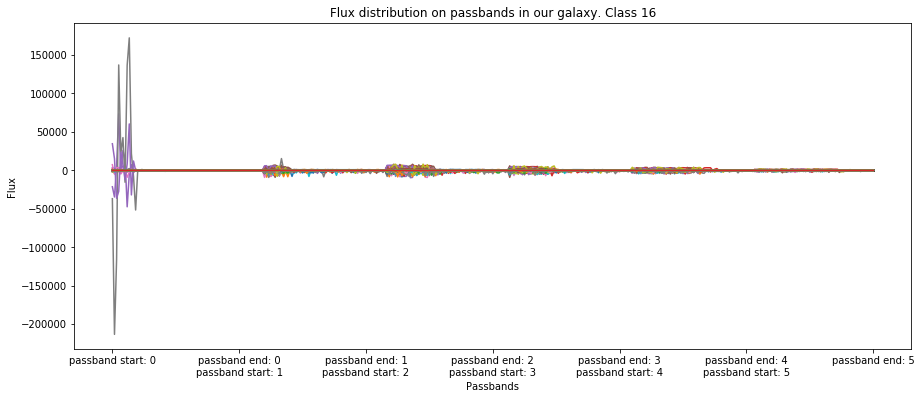

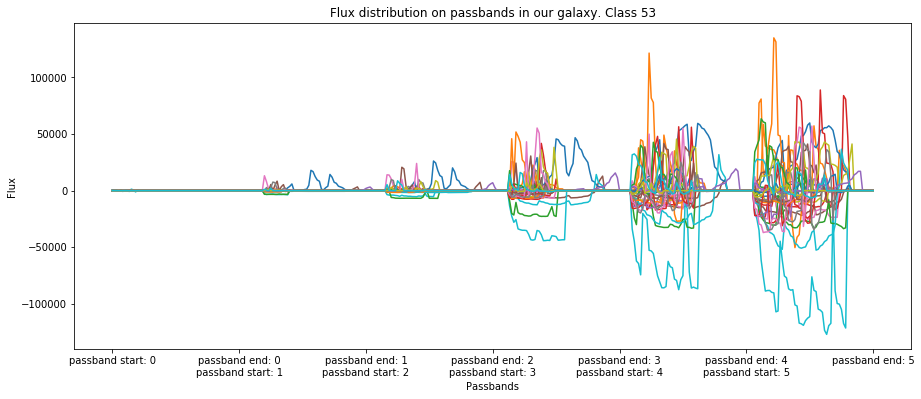

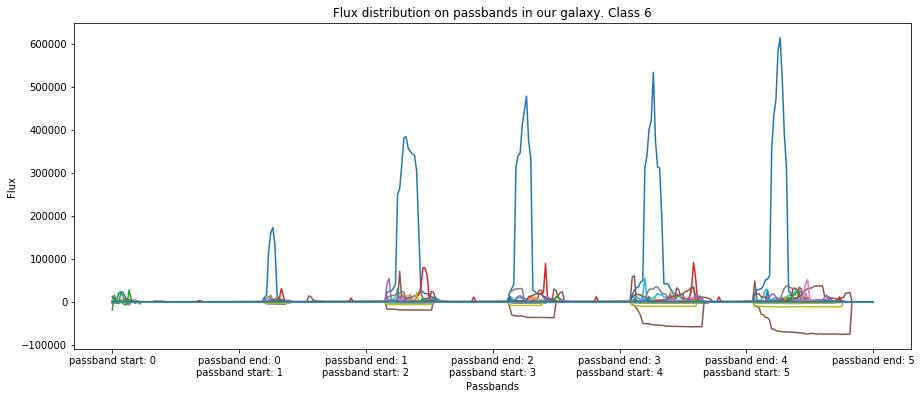

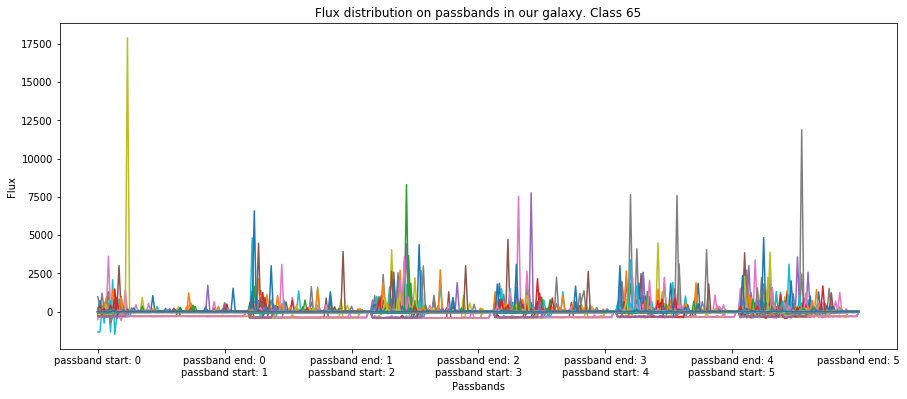

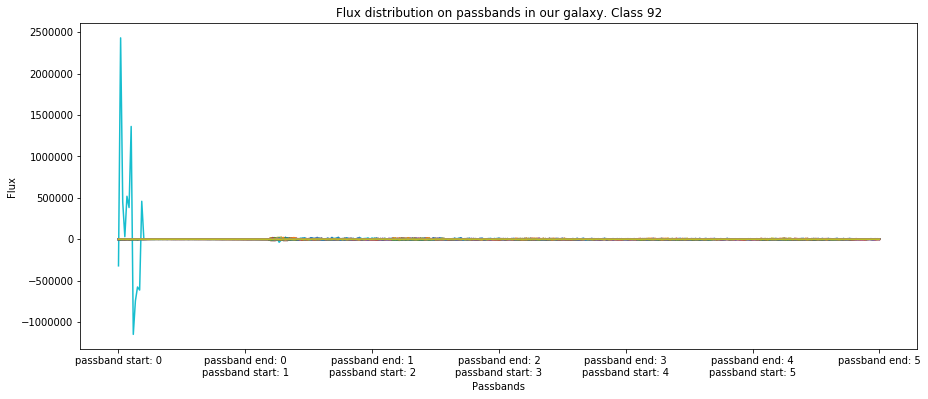

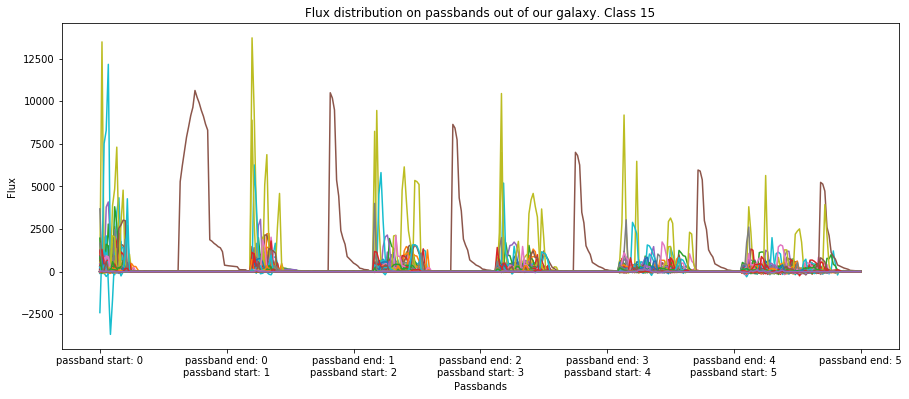

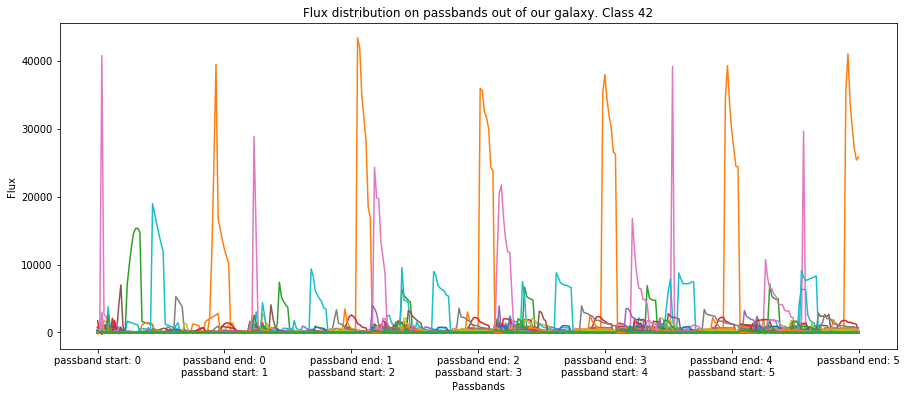

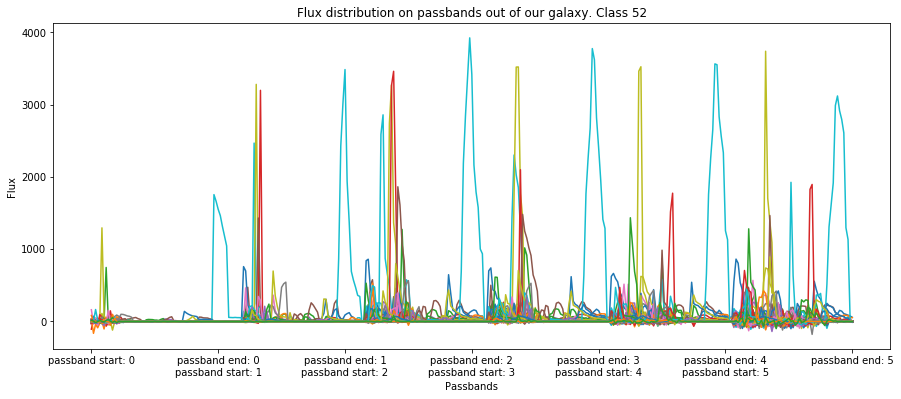

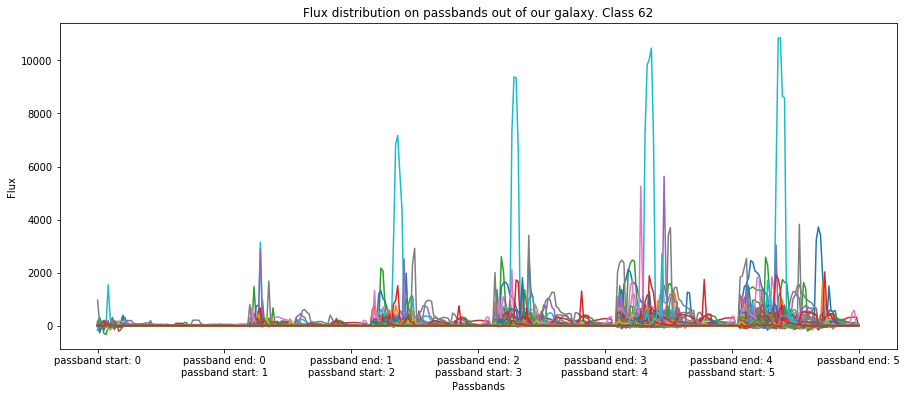

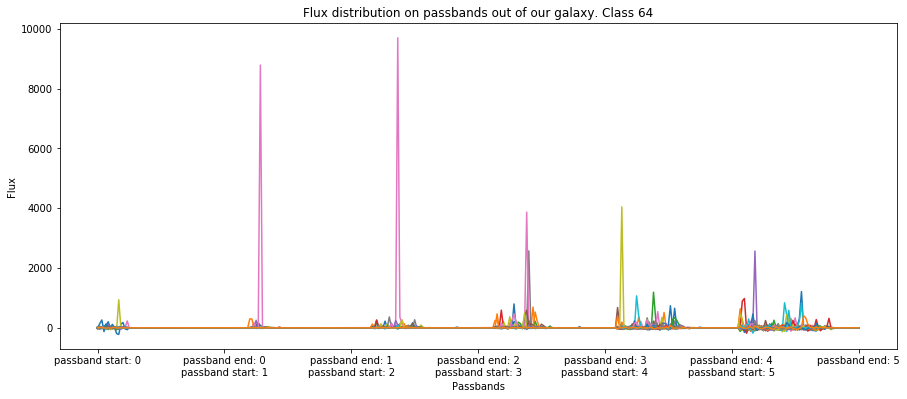

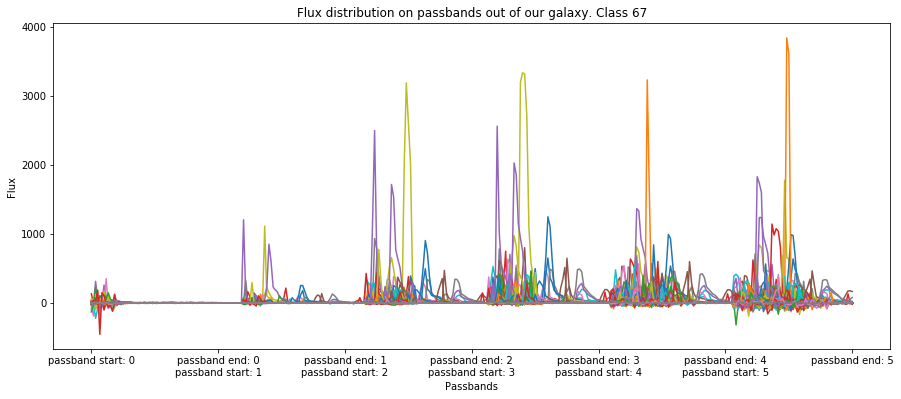

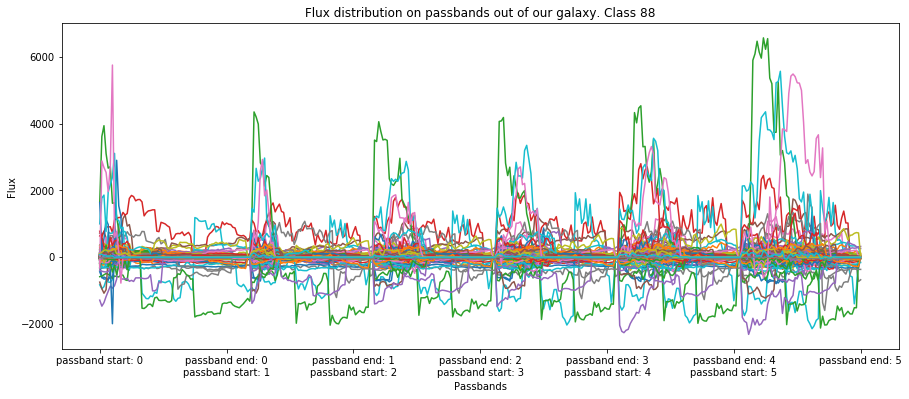

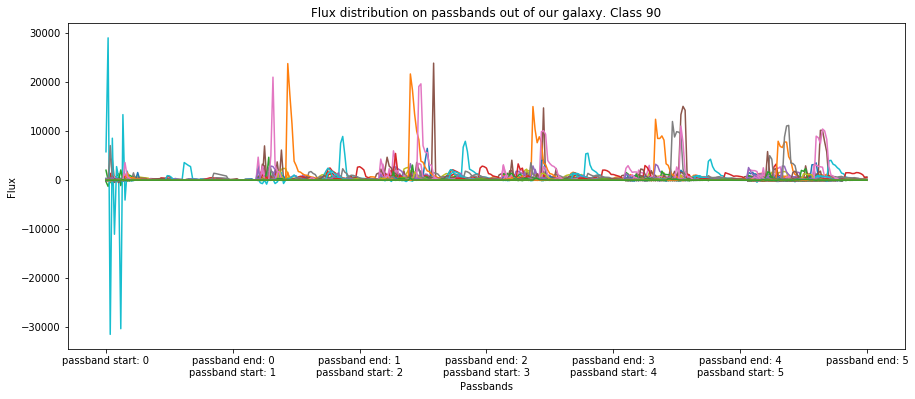

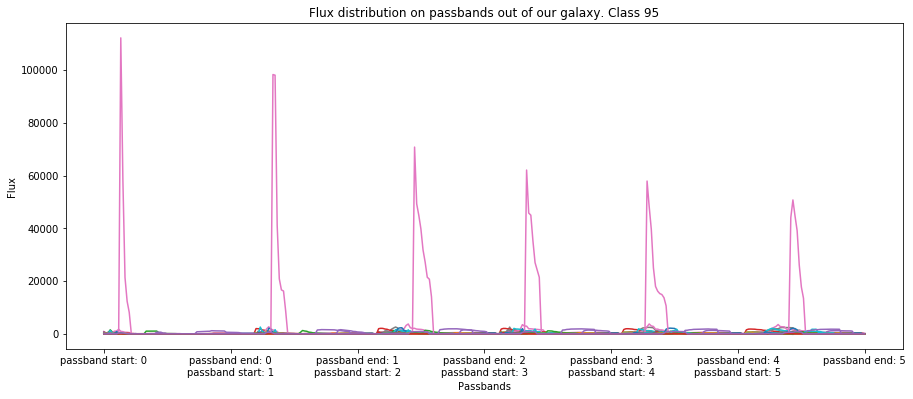

In [10]:
# should be corrected for clarity (shorted)
fig1, ax1 = plt.subplots(figsize=(15,6))
fig2, ax2 = plt.subplots(figsize=(15,6))
fig3, ax3 = plt.subplots(figsize=(15,6))
fig4, ax4 = plt.subplots(figsize=(15,6))
fig5, ax5 = plt.subplots(figsize=(15,6))
fig6, ax6 = plt.subplots(figsize=(15,6))
fig7, ax7 = plt.subplots(figsize=(15,6))
fig8, ax8 = plt.subplots(figsize=(15,6))
fig9, ax9 = plt.subplots(figsize=(15,6))
fig10, ax10 = plt.subplots(figsize=(15,6))
fig11, ax11 = plt.subplots(figsize=(15,6))
fig12, ax12 = plt.subplots(figsize=(15,6))
fig13, ax13 = plt.subplots(figsize=(15,6))
fig14, ax14 = plt.subplots(figsize=(15,6))
xlabels = ['passband start: 0', 'passband end: 0\npassband start: 1',
         'passband end: 1\npassband start: 2',
         'passband end: 2\npassband start: 3',
         'passband end: 3\npassband start: 4',
         'passband end: 4\npassband start: 5',
         'passband end: 5']

for i in set(training_dataset['object_id']):
    if pass_flu[i][0]['in_our_galaxy'].iloc[0] == 1:
        if pass_flu[i][0]['target'].iloc[0] == 'class_16':
            y = concatention()
            ax1.plot(range(length), y)
        elif pass_flu[i][0]['target'].iloc[0] == 'class_53':
            y = concatention()
            ax2.plot(range(length), y)
        elif pass_flu[i][0]['target'].iloc[0] == 'class_6':
            y = concatention()
            ax3.plot(range(length), y)
        elif pass_flu[i][0]['target'].iloc[0] == 'class_65':
            y = concatention()
            ax4.plot(range(length), y)
        elif pass_flu[i][0]['target'].iloc[0] == 'class_92':
            y = concatention()
            ax5.plot(range(length), y)
    else:
        if pass_flu[i][0]['target'].iloc[0] == 'class_15':
            y = concatention()
            ax6.plot(range(length), y)
        elif pass_flu[i][0]['target'].iloc[0] == 'class_42':
            y = concatention()
            ax7.plot(range(length), y)
        elif pass_flu[i][0]['target'].iloc[0] == 'class_52':
            y = concatention()
            ax8.plot(range(length), y)
        elif pass_flu[i][0]['target'].iloc[0] == 'class_62':
            y = concatention()
            ax9.plot(range(length), y)
        elif pass_flu[i][0]['target'].iloc[0] == 'class_64':
            y = concatention()
            ax10.plot(range(length), y)
        elif pass_flu[i][0]['target'].iloc[0] == 'class_67':
            y = concatention()
            ax11.plot(range(length), y)
        elif pass_flu[i][0]['target'].iloc[0] == 'class_88':
            y = concatention()
            ax12.plot(range(length), y)
        elif pass_flu[i][0]['target'].iloc[0] == 'class_90':
            y = concatention()
            ax13.plot(range(length), y)
        elif pass_flu[i][0]['target'].iloc[0] == 'class_95':
            y = concatention()
            ax14.plot(range(length), y)
            
ax1.set_title('Flux distribution on passbands in our galaxy. Class 16')
ax2.set_title('Flux distribution on passbands in our galaxy. Class 53')
ax3.set_title('Flux distribution on passbands in our galaxy. Class 6')
ax4.set_title('Flux distribution on passbands in our galaxy. Class 65')
ax5.set_title('Flux distribution on passbands in our galaxy. Class 92')
ax6.set_title('Flux distribution on passbands out of our galaxy. Class 15')
ax7.set_title('Flux distribution on passbands out of our galaxy. Class 42')
ax8.set_title('Flux distribution on passbands out of our galaxy. Class 52')
ax9.set_title('Flux distribution on passbands out of our galaxy. Class 62')
ax10.set_title('Flux distribution on passbands out of our galaxy. Class 64')
ax11.set_title('Flux distribution on passbands out of our galaxy. Class 67')
ax12.set_title('Flux distribution on passbands out of our galaxy. Class 88')
ax13.set_title('Flux distribution on passbands out of our galaxy. Class 90')
ax14.set_title('Flux distribution on passbands out of our galaxy. Class 95')
ax1.set_xlabel('Passbands')
ax2.set_xlabel('Passbands')
ax3.set_xlabel('Passbands')
ax4.set_xlabel('Passbands')
ax5.set_xlabel('Passbands')
ax6.set_xlabel('Passbands')
ax7.set_xlabel('Passbands')
ax8.set_xlabel('Passbands')
ax9.set_xlabel('Passbands')
ax10.set_xlabel('Passbands')
ax11.set_xlabel('Passbands')
ax12.set_xlabel('Passbands')
ax13.set_xlabel('Passbands')
ax14.set_xlabel('Passbands')
ax1.set_ylabel('Flux')
ax2.set_ylabel('Flux')
ax3.set_ylabel('Flux')
ax4.set_ylabel('Flux')
ax5.set_ylabel('Flux')
ax6.set_ylabel('Flux')
ax7.set_ylabel('Flux')
ax8.set_ylabel('Flux')
ax9.set_ylabel('Flux')
ax10.set_ylabel('Flux')
ax11.set_ylabel('Flux')
ax12.set_ylabel('Flux')
ax13.set_ylabel('Flux')
ax14.set_ylabel('Flux')
ax1.set_xticks(range(0, length, round(length/6)))
ax2.set_xticks(range(0, length, round(length/6)))
ax3.set_xticks(range(0, length, round(length/6)))
ax4.set_xticks(range(0, length, round(length/6)))
ax5.set_xticks(range(0, length, round(length/6)))
ax6.set_xticks(range(0, length, round(length/6)))
ax7.set_xticks(range(0, length, round(length/6)))
ax8.set_xticks(range(0, length, round(length/6)))
ax9.set_xticks(range(0, length, round(length/6)))
ax10.set_xticks(range(0, length, round(length/6)))
ax11.set_xticks(range(0, length, round(length/6)))
ax12.set_xticks(range(0, length, round(length/6)))
ax13.set_xticks(range(0, length, round(length/6)))
ax14.set_xticks(range(0, length, round(length/6)))
ax1.set_xticklabels(xlabels)
ax2.set_xticklabels(xlabels)
ax3.set_xticklabels(xlabels)
ax4.set_xticklabels(xlabels)
ax5.set_xticklabels(xlabels)
ax6.set_xticklabels(xlabels)
ax7.set_xticklabels(xlabels)
ax8.set_xticklabels(xlabels)
ax9.set_xticklabels(xlabels)
ax10.set_xticklabels(xlabels)
ax11.set_xticklabels(xlabels)
ax12.set_xticklabels(xlabels)
ax13.set_xticklabels(xlabels)
ax14.set_xticklabels(xlabels)

# Computing additional statistical features 
Cesium library usage

In [11]:
from cesium import featurize
features_to_use = ["amplitude",
                   "flux_percentile_ratio_mid20",
                   "flux_percentile_ratio_mid35",
                   "flux_percentile_ratio_mid50",
                   "flux_percentile_ratio_mid65",
                   "flux_percentile_ratio_mid80",
                   "percent_beyond_1_std",
                   "maximum",
                   "max_slope",
                   "median",
                   "median_absolute_deviation",
                   "percent_close_to_median",
                   "percent_difference_flux_percentile",
                   "minimum",
                   "percent_amplitude",
                   "skew",
                   "period_fast",
                   "qso_log_chi2_qsonu",
                   "qso_log_chi2nuNULL_chi2nu",
                   "std",
                   "stetson_j",
                   "stetson_k",
                   "weighted_average",
                   "all_times_nhist_numpeaks",
                   "all_times_nhist_peak1_bin",
                   "all_times_nhist_peak2_bin",
                   "all_times_nhist_peak3_bin",
                   "all_times_nhist_peak4_bin",
                   "all_times_nhist_peak_1_to_2",
                   "all_times_nhist_peak_1_to_3",
                   "all_times_nhist_peak_1_to_4",
                   "all_times_nhist_peak_2_to_3",
                   "all_times_nhist_peak_2_to_4",
                   "all_times_nhist_peak_3_to_4",
                   "all_times_nhist_peak_val",
                   "avg_double_to_single_step",
                   "avg_err",
                   "avgt",
                   "cad_probs_1",
                   "cad_probs_10",
                   "cad_probs_20",
                   "cad_probs_30",
                   "cad_probs_40",
                   "cad_probs_50",
                   "cad_probs_100",
                   "cad_probs_500",
                   "cad_probs_1000",
                   "cad_probs_5000",
                   "cad_probs_10000",
                   "cad_probs_50000",
                   "cad_probs_100000",
                   "cad_probs_500000",
                   "cad_probs_1000000",
                   "cad_probs_5000000",
                   "cad_probs_10000000",
                   "cads_avg",
                   "cads_med",
                   "cads_std",
                   "mean",
                   "med_double_to_single_step",
                   "med_err",
                   "n_epochs",
                   "std_double_to_single_step",
                   "std_err",
                   "total_time"]

***Compute new features by cesium***

In [13]:
gb = dataset.groupby('object_id')
fset_cesium = featurize.featurize_time_series(times=[gb.get_group(x)['mjd'].values for x in gb.groups],
                                              values=[gb.get_group(x)['flux'].values for x in gb.groups],
                                              errors=[gb.get_group(x)['flux_err'].values for x in gb.groups],
                                              features_to_use=features_to_use)

In [ ]:
fset_cesium.insert(loc=0, column='object_id', value=dataset.groupby('object_id').sum().index)

In [ ]:
fset_cesium.columns = fset_cesium.columns.droplevel(1)

In [3]:
# fset_cesium.to_csv('fset_cesium.csv')
# fset_cesium = pd.read_csv('fset_cesium.csv', index_col=0)

In [17]:
fset_cesium.head()

,object_id,amplitude,flux_percentile_ratio_mid20,flux_percentile_ratio_mid35,flux_percentile_ratio_mid50,flux_percentile_ratio_mid65,flux_percentile_ratio_mid80,percent_beyond_1_std,maximum,max_slope,...,cads_avg,cads_med,cads_std,mean,med_double_to_single_step,med_err,n_epochs,std_double_to_single_step,std_err,total_time
0,615,880.533203,0.000000,0.000000,0.000000,0.000000,0.000000,0.392045,660.626343,116805.166334,...,2.489431,0.0111,17.326857,-123.096998,0.006542,3.835268,352.0,NaN,1.742267,873.7903
1,713,14.753032,0.001668,0.005248,0.018069,0.123541,0.254958,0.425714,14.770886,1580.576999,...,2.432148,0.0110,18.975828,-1.423351,0.007325,1.998217,350.0,NaN,1.507730,848.8198
2,730,33.234935,0.028363,0.053155,0.095119,0.152027,0.448602,0.154545,47.310059,3949.860787,...,2.595275,0.0110,18.160894,2.267434,0.006387,1.990851,330.0,NaN,1.718524,853.8455
3,745,118.144837,0.024878,0.048751,0.082448,0.147631,0.291170,0.082621,220.795212,11188.062767,...,2.439160,0.0111,16.745572,8.909206,0.006367,1.819875,351.0,NaN,3.532281,853.7060
4,1124,80.071971,0.009432,0.016523,0.025336,0.042001,0.120672,0.096591,143.600189,13330.938698,...,2.489431,0.0111,17.326857,7.145702,0.006542,2.214854,352.0,NaN,1.931089,873.7903


***There are some NaN or Infinity values after computation***

In [19]:
fset_cesium.isnull().sum().head()

object_id                        0
amplitude                        0
flux_percentile_ratio_mid20    132
flux_percentile_ratio_mid35    176
flux_percentile_ratio_mid50    200
dtype: int64

***Impute missing values with median***

In [20]:
imp = Imputer(missing_values=np.nan, strategy='median')
x = imp.fit_transform(fset_cesium.values)
imp = Imputer(missing_values=np.inf, strategy='median')
x = imp.fit_transform(x)

In [21]:
fset_cesium_imputed = pd.DataFrame(data=x, columns=fset_cesium.columns)

In [4]:
# fset_cesium_imputed.to_csv('fset_cesium_imputed.csv')
# fset_cesium_imputed = pd.read_csv('fset_cesium_imputed.csv', index_col=0)

In [5]:
fset_cesium_imputed['object_id'] = fset_cesium_imputed['object_id'].apply(np.int)
fset_cesium_imputed.head()

,object_id,amplitude,flux_percentile_ratio_mid20,flux_percentile_ratio_mid35,flux_percentile_ratio_mid50,flux_percentile_ratio_mid65,flux_percentile_ratio_mid80,percent_beyond_1_std,maximum,max_slope,...,cads_avg,cads_med,cads_std,mean,med_double_to_single_step,med_err,n_epochs,std_double_to_single_step,std_err,total_time
0,615,880.533203,0.000000,0.000000,0.000000,0.000000,0.000000,0.392045,660.626343,116805.166334,...,2.489431,0.0111,17.326857,-123.096998,0.006542,3.835268,352.0,194.500737,1.742267,873.7903
1,713,14.753032,0.001668,0.005248,0.018069,0.123541,0.254958,0.425714,14.770886,1580.576999,...,2.432148,0.0110,18.975828,-1.423351,0.007325,1.998217,350.0,194.500737,1.507730,848.8198
2,730,33.234935,0.028363,0.053155,0.095119,0.152027,0.448602,0.154545,47.310059,3949.860787,...,2.595275,0.0110,18.160894,2.267434,0.006387,1.990851,330.0,194.500737,1.718524,853.8455
3,745,118.144837,0.024878,0.048751,0.082448,0.147631,0.291170,0.082621,220.795212,11188.062767,...,2.439160,0.0111,16.745572,8.909206,0.006367,1.819875,351.0,194.500737,3.532281,853.7060
4,1124,80.071971,0.009432,0.016523,0.025336,0.042001,0.120672,0.096591,143.600189,13330.938698,...,2.489431,0.0111,17.326857,7.145702,0.006542,2.214854,352.0,194.500737,1.931089,873.7903


# Computing additional features (manual)

In [7]:
# extract each passband
for key, val in {'u': 0, 'g': 1, 'r': 2, 'i': 3, 'z': 4, 'y': 5}.items():
    dataset[key] = (dataset['passband']-val).apply(np.bool).apply(np.logical_not).apply(np.int)
dataset.head()

,object_id,mjd,passband,flux,flux_err,detected,u,g,r,i,z,y
0,615,59750.4229,2,-544.810303,3.622952,1,0,0,1,0,0,0
1,615,59750.4306,1,-816.434326,5.553370,1,0,1,0,0,0,0
2,615,59750.4383,3,-471.385529,3.801213,1,0,0,0,1,0,0
3,615,59750.4450,4,-388.984985,11.395031,1,0,0,0,0,1,0
4,615,59752.4070,2,-681.858887,4.041204,1,0,0,1,0,0,0


In [8]:
import gc
gc.enable()
dataset['flux_ratio_sq'] = np.power(dataset['flux'] / dataset['flux_err'], 2.0)
dataset['flux_by_flux_ratio_sq'] = dataset['flux'] * dataset['flux_ratio_sq']

aggs = {
    'mjd': ['min', 'max', 'size'],
    'passband': ['min', 'max', 'mean', 'median', 'std'],
    'flux': ['min', 'max', 'mean', 'median', 'std','skew'],
    'flux_err': ['min', 'max', 'mean', 'median', 'std','skew'],
    'detected': ['mean'],
    'flux_ratio_sq':['sum','skew'],
    'flux_by_flux_ratio_sq':['sum','skew'],
    'r': ['sum', 'mean'],
    'g': ['sum', 'mean'],
    'i': ['sum', 'mean'],
    'u': ['sum', 'mean'],
    'z': ['sum', 'mean'],
    'y': ['sum', 'mean'],
}

agg_train = dataset.groupby('object_id').agg(aggs)
new_columns = [k + '_' + agg for k in aggs.keys() for agg in aggs[k]]
agg_train.columns = new_columns
agg_train['mjd_diff'] = agg_train['mjd_max'] - agg_train['mjd_min']
agg_train['flux_diff'] = agg_train['flux_max'] - agg_train['flux_min']
agg_train['flux_dif2'] = (agg_train['flux_max'] - agg_train['flux_min']) / agg_train['flux_mean']
agg_train['flux_w_mean'] = agg_train['flux_by_flux_ratio_sq_sum'] / agg_train['flux_ratio_sq_sum']
agg_train['flux_dif3'] = (agg_train['flux_max'] - agg_train['flux_min']) / agg_train['flux_w_mean']

del agg_train['mjd_max'], agg_train['mjd_min']
agg_train.head()

gc.collect()

140

In [9]:
agg_train = agg_train.reset_index()

In [10]:
agg_train.head()

,object_id,mjd_size,passband_min,passband_max,passband_mean,passband_median,passband_std,flux_min,flux_max,flux_mean,...,u_mean,z_sum,z_mean,y_sum,y_mean,mjd_diff,flux_diff,flux_dif2,flux_w_mean,flux_dif3
0,615,352,0,5,2.457386,2.0,1.720797,-1100.440063,660.626343,-123.096998,...,0.178977,58,0.164773,57,0.161932,873.7903,1761.066406,-14.306331,-327.742307,-5.373326
1,713,350,0,5,2.400000,2.0,1.746056,-14.735178,14.770886,-1.423351,...,0.200000,56,0.160000,56,0.160000,848.8198,29.506064,-20.730002,-4.884564,-6.040676
2,730,330,0,5,2.336364,2.0,1.758750,-19.159811,47.310059,2.267434,...,0.218182,51,0.154545,51,0.154545,853.8455,66.469870,29.315018,25.373110,2.619697
3,745,351,0,5,2.378917,2.0,1.747328,-15.494463,220.795212,8.909206,...,0.205128,56,0.159544,55,0.156695,853.7060,236.289675,26.521968,152.835617,1.546038
4,1124,352,0,5,2.457386,2.0,1.720797,-16.543753,143.600189,7.145702,...,0.178977,58,0.164773,57,0.161932,873.7903,160.143942,22.411225,87.856390,1.822792


In [11]:
agg_train.shape

(7848, 41)

In [12]:
fset_cesium_imputed.shape

(7848, 66)

***Merging two training datasets (manually computed features and from cesium)***

In [13]:
mer_data = pd.merge(agg_train, fset_cesium_imputed)

In [14]:
mer_data.shape

(7848, 106)

In [15]:
mer_data.head()

,object_id,mjd_size,passband_min,passband_max,passband_mean,passband_median,passband_std,flux_min,flux_max,flux_mean,...,cads_avg,cads_med,cads_std,mean,med_double_to_single_step,med_err,n_epochs,std_double_to_single_step,std_err,total_time
0,615,352,0,5,2.457386,2.0,1.720797,-1100.440063,660.626343,-123.096998,...,2.489431,0.0111,17.326857,-123.096998,0.006542,3.835268,352.0,194.500737,1.742267,873.7903
1,713,350,0,5,2.400000,2.0,1.746056,-14.735178,14.770886,-1.423351,...,2.432148,0.0110,18.975828,-1.423351,0.007325,1.998217,350.0,194.500737,1.507730,848.8198
2,730,330,0,5,2.336364,2.0,1.758750,-19.159811,47.310059,2.267434,...,2.595275,0.0110,18.160894,2.267434,0.006387,1.990851,330.0,194.500737,1.718524,853.8455
3,745,351,0,5,2.378917,2.0,1.747328,-15.494463,220.795212,8.909206,...,2.439160,0.0111,16.745572,8.909206,0.006367,1.819875,351.0,194.500737,3.532281,853.7060
4,1124,352,0,5,2.457386,2.0,1.720797,-16.543753,143.600189,7.145702,...,2.489431,0.0111,17.326857,7.145702,0.006542,2.214854,352.0,194.500737,1.931089,873.7903


# More data exploratory

In [16]:
meta_dataset = pd.read_csv("/media/amadeusz/78F69DA1F69D6064/Users/Amadeusz/Downloads/all/training_set_metadata.csv")
column_names = {6: "class_6", 15: "class_15", 16: "class_16", 42: "class_42", 52: "class_52", 53: "class_53",
                62: "class_62", 64: "class_64", 65: "class_65", 67: "class_67", 88: "class_88", 90: "class_90",
                92: "class_92", 95: "class_95"}
meta_dataset["target"] = list(map(lambda name: column_names[name], meta_dataset["target"]))
meta_dataset.head()

# ra - right ascension, sky coordinate: co-longitude in degrees. Float32
#
# decl - declination, sky coordinate: co-latitude in degrees. Float32
#
# gal_l - galactic longitude in degrees. Float32
#
# gal_b - galactic latitude in degrees. Float32
#
# ddf - A flag to identify the object as coming from the DDF survey area 
#       (with value DDF = 1 for the DDF, DDF = 0 for the WFD survey). 
#       Note that while the DDF fields are contained within the full WFD survey area, the DDF fluxes have 
#       significantly smaller uncertainties. Boolean
#
# hostgal_specz - the spectroscopic redshift of the source. This is an extremely accurate measure of redshift, 
#                 available for the training set and a small fraction of the test set. Float32
#
# hostgal_photoz - The photometric redshift of the host galaxy of the astronomical source. 
#                  While this is meant to be a proxy for hostgal_specz, there can be large differences between 
#                  the two and should be regarded as a far less accurate version of hostgal_specz. Float32
#
# hostgal_photoz_err - The uncertainty on the hostgal_photoz based on LSST survey projections. Float32
# 
# distmod - The distance to the source calculated from hostgal_photoz and using general relativity. Float32
# 
# mwebv - MW E(B-V). this ‘extinction’ of light is a property of the Milky Way (MW) dust along the line of sight 
#         to the astronomical source, and is thus a function of the sky coordinates of the source ra, decl. 
#       This is used to determine a passband dependent dimming and redenning of light from astronomical sources 
#       as described in subsection 2.1, and based on the Schlafly et al. (2011) and Schlegel et al. (1998) dust models. Float32

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,class_92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,class_88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,class_42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,class_90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,class_90


In [17]:
# from description -> NaN values in "distmod" teels us that this object is in our galaxy (no redshift provided/hostgal),
# distmod is calculated from redshift via general relativity
# create new features (in_our_galaxy)
meta_dataset['in_our_galaxy'] = meta_dataset['distmod'].apply(np.isnan).astype(int)
meta_dataset.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,in_our_galaxy
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,class_92,1
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,class_88,0
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,class_42,0
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,class_90,0
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,class_90,0


# Empty value veryfication

In [18]:
meta_dataset.isnull().sum()

object_id                0
ra                       0
decl                     0
gal_l                    0
gal_b                    0
ddf                      0
hostgal_specz            0
hostgal_photoz           0
hostgal_photoz_err       0
distmod               2325
mwebv                    0
target                   0
in_our_galaxy            0
dtype: int64

In [19]:
print("distmod missing data in %: {}".format(meta_dataset.isnull().sum()[-4]*100/meta_dataset.shape[0]))

distmod missing data in %: 29.625382262996943


In [20]:
# put 0 instead of NaN in distmod (in that way we can store distance for objects out of our galaxy)
meta_dataset = meta_dataset.fillna(0)
meta_dataset.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,in_our_galaxy
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,0.0000,0.017,class_92,1
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,class_88,0
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,class_42,0
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,class_90,0
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,class_90,0


In [21]:
meta_dataset.isnull().sum()

object_id             0
ra                    0
decl                  0
gal_l                 0
gal_b                 0
ddf                   0
hostgal_specz         0
hostgal_photoz        0
hostgal_photoz_err    0
distmod               0
mwebv                 0
target                0
in_our_galaxy         0
dtype: int64

# Drop columns contain not valuable data
Training dataset contains hostgal_specz data, but test dataset (see next cells) do not.

In [22]:
meta_dataset = meta_dataset.drop(['hostgal_specz'], axis=1)
meta_dataset.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,in_our_galaxy
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,0.017,class_92,1
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.6267,0.2552,45.4063,0.007,class_88,0
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2262,0.0157,40.2561,0.021,class_42,0
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.2813,1.1523,40.7951,0.007,class_90,0
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.2415,0.0176,40.4166,0.024,class_90,0


# Plot objects on the sky map (per target class)

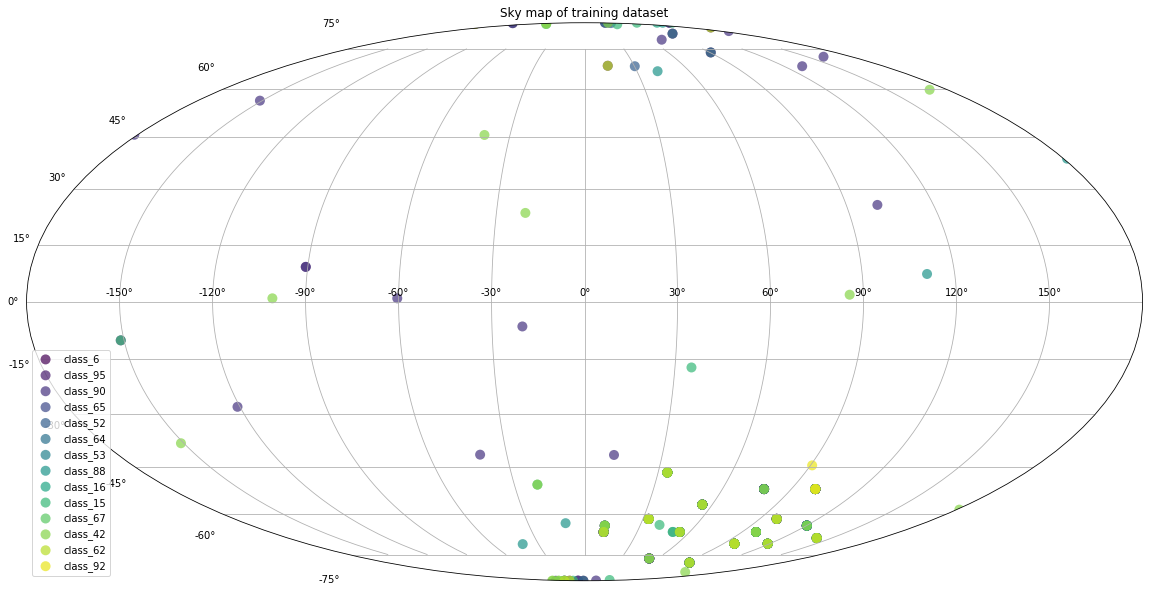

In [23]:
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111, projection='mollweide')
data = meta_dataset[['ra', 'decl']]
data['target'] = meta_dataset['target']
category = list()
colors = plt.get_cmap('viridis').colors[::19]
for cat in set(meta_dataset['target']):
    category.append(data[data['target'].str.contains(cat)])
classes = list(set(meta_dataset['target']))
for cat, color, class_ in zip(category, colors, classes):
    ax.scatter(cat['ra'], cat['decl'], c=color, label=class_, edgecolors='none', s=100, alpha=0.7)
ax.legend()
ax.grid(True)
plt.title('Sky map of training dataset')
fig.savefig('sky_train_plot.pdf')

# How many objects of different type are in our galaxy?
We can clearly see that in our galaxy there are only specific type of objects (classes: 16, 53, 6, 65, 92).  
In test data we can cluster objects based on that.

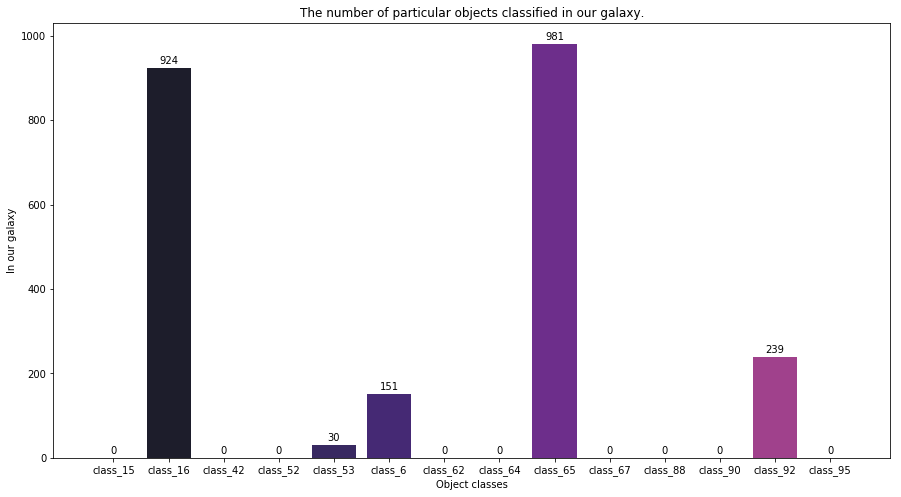

In [45]:
colors = plt.get_cmap('magma').colors[::9]
data = meta_dataset[['target', 'in_our_galaxy']]
data['in_our_galaxy'] = data['in_our_galaxy']
data = data.groupby('target').sum()
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)
ax.bar(data.index, data['in_our_galaxy'], color=colors, alpha=0.9)
ax.set_xlabel('Object classes')
ax.set_ylabel('In our galaxy')
plt.title('The number of particular objects classified in our galaxy.')
for i, rect in enumerate(data['in_our_galaxy']):
    ax.text(i, rect+10,rect, ha='center')

# Comparison of WFD and DDF objects detection number.  
PLAsTiCC simulates the "Wide-Fast-Deep" Survey - the main LSST program, and the "Deep Drilling Fields" - a few small regions where LSST will get more observations for specialized scientific studies.

Which objects are in the WFD vs the DDF are specified by the ddf_bool column in the header (1 if in DDF, 0 otherwise).

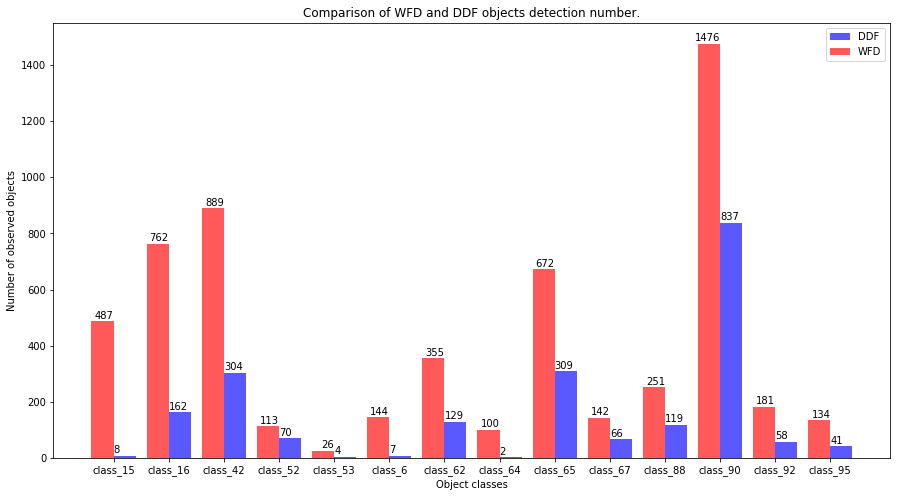

In [46]:
colors = plt.get_cmap('magma').colors[::14]
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)

data = meta_dataset[['target', 'ddf']]
data = data.groupby('target').sum()
p1 = ax.bar(np.arange(len(data.index))+0.2, data['ddf'], color='blue', alpha=0.65, width=0.4)
for i, rect in enumerate(data['ddf']):
    ax.text(i, rect+10,rect, ha='left')
    
data_2 = meta_dataset[['target', 'ddf']]
data_2['wfd'] = np.logical_xor(data_2['ddf'],1).astype(int)
data_2 = data_2.groupby('target').sum()
p2 = ax.bar(np.arange(len(data_2.index))-0.2, data_2['wfd'], color='red', alpha=0.65, width=0.4)
for i, rect in enumerate(data_2['wfd']):
    ax.text(i, rect+10,rect, ha='right')
    
ax.set_xticklabels(data.index)
ax.set_xticks(np.arange(len(data_2.index)))
ax.set_xlabel('Object classes')
ax.set_ylabel('Number of observed objects')
plt.title('Comparison of WFD and DDF objects detection number.')
ax.legend((p1,p2), ['DDF', 'WFD'])

***Check missing data in test dataset***

Based on that we can remove non valuable feature from training dataset (hostgal_specz).  
Hostgal_specz is a feature where scientist/astronomers measured very precisly redshift of particular object.
It is time consuming so mostly in all test observation we do not have such deep precision.
Instead of this, scientist measured hostgal_photoz which is far less accurate.

In [48]:
meta_test = pd.read_csv('/media/amadeusz/78F69DA1F69D6064/Users/Amadeusz/Downloads/all/test_set_metadata.csv')
n_samples = meta_test.shape[0]
missing_values = meta_test.isnull().sum()

In [49]:
for val, ind in zip(missing_values, missing_values.index):
    print("{} has {:2.2f}%  missing values.".format(ind, val*100/n_samples))
# hostgal_specz - missing 96%+ samples -> insufficient data for analysis and ML algorithms, need to be dropped
%xdel meta_test

object_id has 0.00%  missing values.
ra has 0.00%  missing values.
decl has 0.00%  missing values.
gal_l has 0.00%  missing values.
gal_b has 0.00%  missing values.
ddf has 0.00%  missing values.
hostgal_specz has 96.55%  missing values.
hostgal_photoz has 0.00%  missing values.
hostgal_photoz_err has 0.00%  missing values.
distmod has 11.18%  missing values.
mwebv has 0.00%  missing values.


# Merg training dataset and meta_dataset

In [24]:
training_dataset = pd.merge(mer_data, meta_dataset) # with additional computed features
training_dataset.head()

,object_id,mjd_size,passband_min,passband_max,passband_mean,passband_median,passband_std,flux_min,flux_max,flux_mean,...,decl,gal_l,gal_b,ddf,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,in_our_galaxy
0,615,352,0,5,2.457386,2.0,1.720797,-1100.440063,660.626343,-123.096998,...,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,0.017,class_92,1
1,713,350,0,5,2.400000,2.0,1.746056,-14.735178,14.770886,-1.423351,...,-27.784405,223.525509,-54.460748,1,1.6267,0.2552,45.4063,0.007,class_88,0
2,730,330,0,5,2.336364,2.0,1.758750,-19.159811,47.310059,2.267434,...,-6.579593,170.455585,-61.548219,1,0.2262,0.0157,40.2561,0.021,class_42,0
3,745,351,0,5,2.378917,2.0,1.747328,-15.494463,220.795212,8.909206,...,-45.586655,328.254458,-68.969298,1,0.2813,1.1523,40.7951,0.007,class_90,0
4,1124,352,0,5,2.457386,2.0,1.720797,-16.543753,143.600189,7.145702,...,-63.823658,316.922299,-51.059403,1,0.2415,0.0176,40.4166,0.024,class_90,0


In [26]:
# training_dataset.to_csv('training_dataset.csv', index=False)
training_dataset = pd.read_csv('training_dataset.csv', index_col=0)
training_dataset.head()

,mjd_size,passband_min,passband_max,passband_mean,passband_median,passband_std,flux_min,flux_max,flux_mean,flux_median,...,decl,gal_l,gal_b,ddf,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,in_our_galaxy
object_id,,,,,,,,,,,,,,,,,,,,,
615,352,0,5,2.457386,2.0,1.720797,-1100.440063,660.626343,-123.096998,-89.477524,...,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,0.017,class_92,1
713,350,0,5,2.400000,2.0,1.746056,-14.735178,14.770886,-1.423351,-0.873033,...,-27.784405,223.525509,-54.460748,1,1.6267,0.2552,45.4063,0.007,class_88,0
730,330,0,5,2.336364,2.0,1.758750,-19.159811,47.310059,2.267434,0.409172,...,-6.579593,170.455585,-61.548219,1,0.2262,0.0157,40.2561,0.021,class_42,0
745,351,0,5,2.378917,2.0,1.747328,-15.494463,220.795212,8.909206,1.035895,...,-45.586655,328.254458,-68.969298,1,0.2813,1.1523,40.7951,0.007,class_90,0
1124,352,0,5,2.457386,2.0,1.720797,-16.543753,143.600189,7.145702,1.141288,...,-63.823658,316.922299,-51.059403,1,0.2415,0.0176,40.4166,0.024,class_90,0


# The number of object detected in particular passband

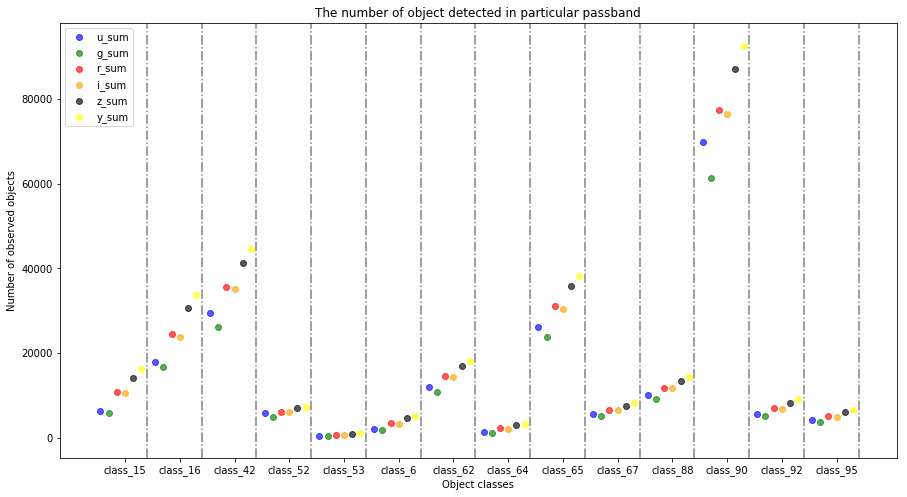

In [27]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)

data = training_dataset[['target', 'g_sum', 'r_sum', 'z_sum', 'u_sum', 'i_sum', 'y_sum']]
data = data.groupby('target').sum()
x = np.arange(len(data.index))
for i in range(len(data.index)):
    ax.axvline(x=i+0.4, linestyle='-.', color='grey')
    
p1 = ax.scatter(x-0.45, data['u_sum'], color='blue', alpha=0.65)
p2 = ax.scatter(x-0.3, data['g_sum'], color='green', alpha=0.65)
p3 = ax.scatter(x-0.15, data['r_sum'], color='red', alpha=0.65)
p4 = ax.scatter(x, data['i_sum'], color='orange', alpha=0.65)
p5 = ax.scatter(x+0.15, data['z_sum'], color='black', alpha=0.65)
p6 = ax.scatter(x+0.3, data['y_sum'], color='yellow', alpha=0.65)

ax.set_xticklabels(data.index)
ax.set_xticks(np.arange(len(data.index)))
ax.set_xlabel('Object classes')
ax.set_ylabel('Number of observed objects')
plt.title('The number of object detected in particular passband')
ax.legend((p1,p2, p3, p4, p5, p6), ['u_sum', 'g_sum', 'r_sum', 'i_sum', 'z_sum', 'y_sum'])

# Training data histograms
Warning: huge computing time

In [ ]:
for col in training_dataset.columns.values:
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    training_dataset[col].hist(bins=100, ax=ax)

In [ ]:
# histograms per class
targets = set(training_dataset['target'])
for target in targets:
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    training_dataset[training_dataset['target'].str.contains(target)].hist(bins=100, ax=ax)
    fig.suptitle('{} histograms'.format(target), fontsize=16)

***Correlation heatmap***  

Ned to correct this, need to be readable

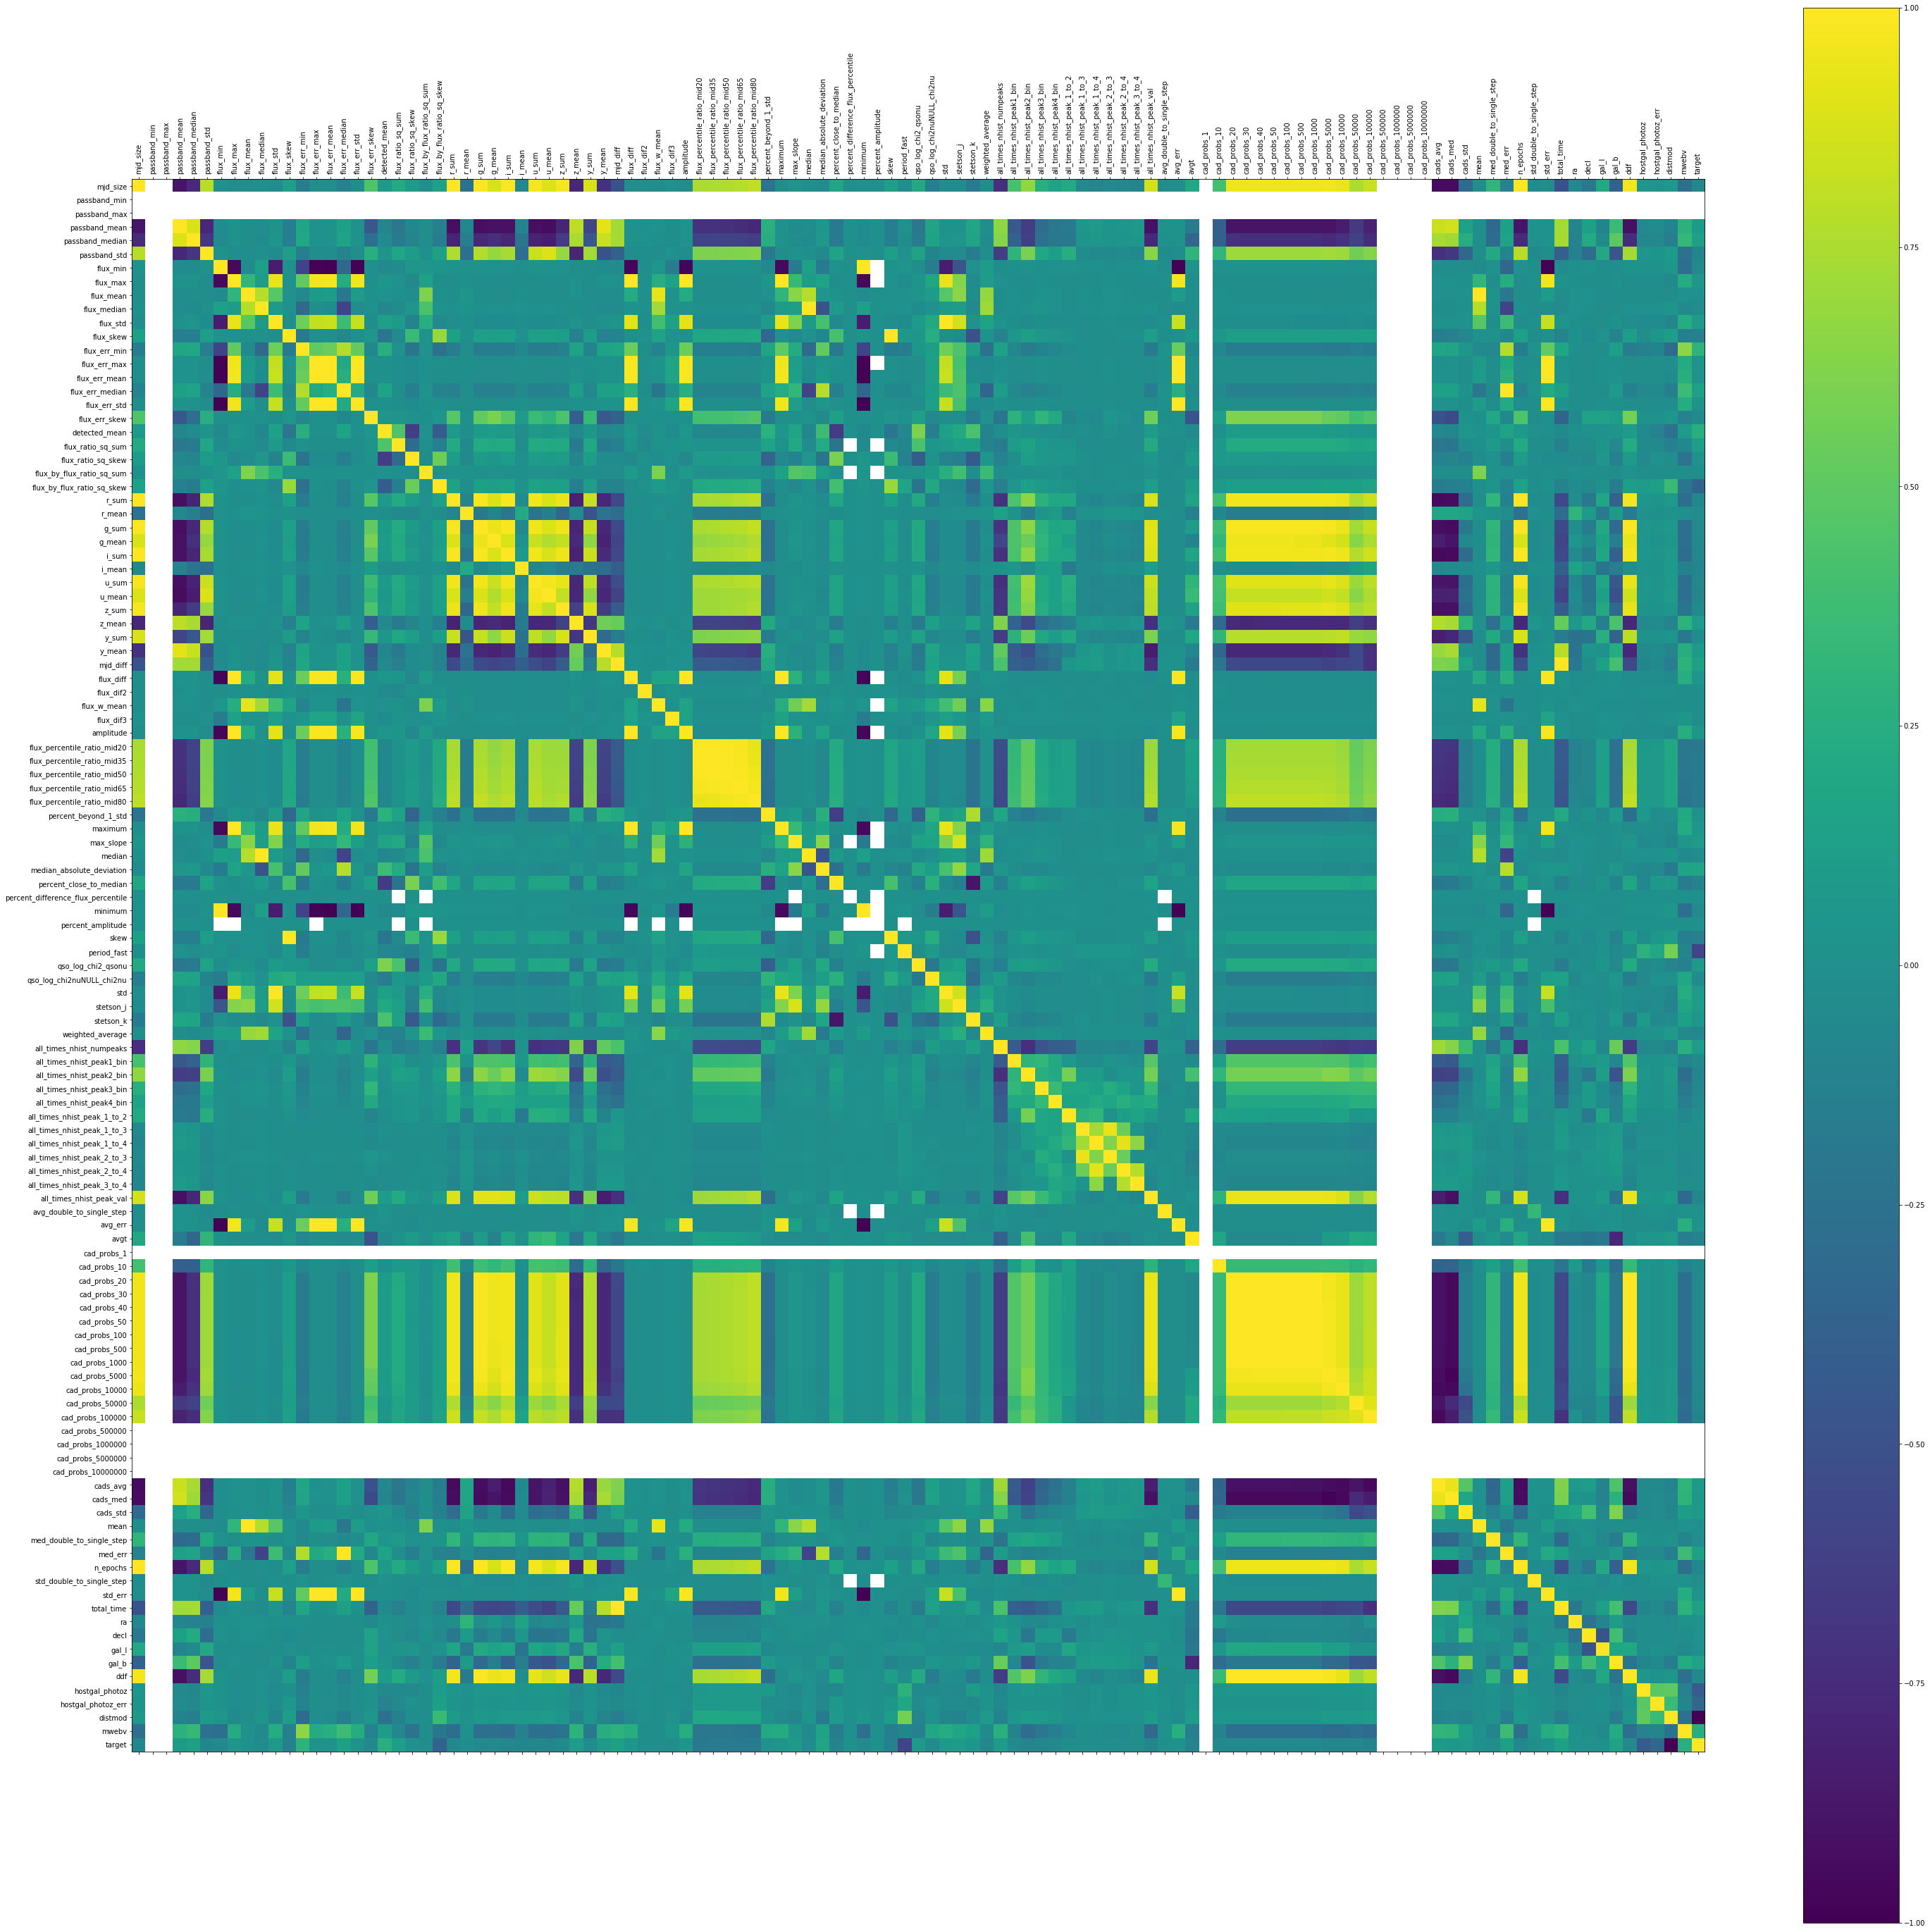

In [30]:
correlation = training_dataset.corr()
fig = plt.figure(figsize=(50,50))
ax = fig.add_subplot(111)
cax = ax.matshow(correlation, vmin=-1, vmax=1, interpolation='none')
ticks = [i for i in range(training_dataset.shape[1])]
ticklabels = training_dataset.columns.values.tolist()
plt.xticks(ticks, ticklabels, rotation='vertical')
plt.yticks(ticks, ticklabels)
ax.axis('image')
# Text on the plot
# for y, row in enumerate(correlation.values):
#     for x, val in enumerate(row):
#         ax.text(x, y, format(val, '.2f'), color='black', ha='center', va='center')   
fig.colorbar(cax)
fig.savefig('training_dataset_correlation_plot.pdf')

# Prepare training data and labels

In [32]:
training_dataset = pd.read_csv('training_dataset.csv', index_col=0)
training_dataset.head()

,mjd_size,passband_min,passband_max,passband_mean,passband_median,passband_std,flux_min,flux_max,flux_mean,flux_median,...,decl,gal_l,gal_b,ddf,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,in_our_galaxy
object_id,,,,,,,,,,,,,,,,,,,,,
615,352,0,5,2.457386,2.0,1.720797,-1100.440063,660.626343,-123.096998,-89.477524,...,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,0.017,class_92,1
713,350,0,5,2.400000,2.0,1.746056,-14.735178,14.770886,-1.423351,-0.873033,...,-27.784405,223.525509,-54.460748,1,1.6267,0.2552,45.4063,0.007,class_88,0
730,330,0,5,2.336364,2.0,1.758750,-19.159811,47.310059,2.267434,0.409172,...,-6.579593,170.455585,-61.548219,1,0.2262,0.0157,40.2561,0.021,class_42,0
745,351,0,5,2.378917,2.0,1.747328,-15.494463,220.795212,8.909206,1.035895,...,-45.586655,328.254458,-68.969298,1,0.2813,1.1523,40.7951,0.007,class_90,0
1124,352,0,5,2.457386,2.0,1.720797,-16.543753,143.600189,7.145702,1.141288,...,-63.823658,316.922299,-51.059403,1,0.2415,0.0176,40.4166,0.024,class_90,0


In [33]:
# separate labels
Y = training_dataset['target']
Y.head()

object_id
615     class_92
713     class_88
730     class_42
745     class_90
1124    class_90
Name: target, dtype: object

In [35]:
# separate training values (exclude labels and object_id)
X = training_dataset.drop(['target'], axis=1)
X.head()

,mjd_size,passband_min,passband_max,passband_mean,passband_median,passband_std,flux_min,flux_max,flux_mean,flux_median,...,ra,decl,gal_l,gal_b,ddf,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,in_our_galaxy
object_id,,,,,,,,,,,,,,,,,,,,,
615,352,0,5,2.457386,2.0,1.720797,-1100.440063,660.626343,-123.096998,-89.477524,...,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,0.017,1
713,350,0,5,2.400000,2.0,1.746056,-14.735178,14.770886,-1.423351,-0.873033,...,53.085938,-27.784405,223.525509,-54.460748,1,1.6267,0.2552,45.4063,0.007,0
730,330,0,5,2.336364,2.0,1.758750,-19.159811,47.310059,2.267434,0.409172,...,33.574219,-6.579593,170.455585,-61.548219,1,0.2262,0.0157,40.2561,0.021,0
745,351,0,5,2.378917,2.0,1.747328,-15.494463,220.795212,8.909206,1.035895,...,0.189873,-45.586655,328.254458,-68.969298,1,0.2813,1.1523,40.7951,0.007,0
1124,352,0,5,2.457386,2.0,1.720797,-16.543753,143.600189,7.145702,1.141288,...,352.711273,-63.823658,316.922299,-51.059403,1,0.2415,0.0176,40.4166,0.024,0


# Cross Validation with different algorithms  
Version with all computed features

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
import time
models = {"LogisticRegression": LogisticRegression(), "DecisionTreeClassifier": DecisionTreeClassifier(), 
          "KNeighborsClassifier": KNeighborsClassifier(), "LinearDiscriminantAnalysis": LinearDiscriminantAnalysis(),
          "GaussianNB": GaussianNB(), "SVC": SVC(probability=True), "AdaBoostClassifier": AdaBoostClassifier(), 
          "GradientBoostingClassifier": GradientBoostingClassifier(), "RandomForestClassifier": RandomForestClassifier(),
          "ExtraTreesClassifier": ExtraTreesClassifier(), "XGBClassifier": XGBClassifier(),
          "LGBMClassifier": LGBMClassifier()}
models_score = pd.DataFrame(columns=["Model", "Mean", "Std", "Time"], data=np.zeros((len(models),4)))
for i, (name, model) in enumerate(models.items()):
    clf = make_pipeline(StandardScaler(), model)
    # perform cross validation (compute mean and std from 5 random treinings and predictions per algorithm)
    # scoring -> neg_log_loss (closer to 0 is better)
    # explenation of log_loss
    # https://stackoverflow.com/questions/35013822/log-loss-output-is-greater-than-1
    start = time.time()
    scores = cross_val_score(clf, X.values, Y, cv=5, scoring="neg_log_loss", n_jobs=-1)
    end = time.time()
    print("Log Loss: {:0.2f} (+/- {:0.2f}) Model: {} Elapsed time: {}".format(scores.mean(), scores.std() * 2, name, end-start))
    # store results in dataframe
    models_score["Model"][i] = name
    models_score["Mean"][i] = scores.mean()
    models_score["Std"][i] = scores.std()
    models_score["Time"][i] = end-start

Log Loss: -1.04 (+/- 0.08) Model: LogisticRegression Elapsed time: 19.77273178100586
Log Loss: -13.97 (+/- 1.09) Model: DecisionTreeClassifier Elapsed time: 1.6692397594451904
Log Loss: -8.55 (+/- 3.96) Model: KNeighborsClassifier Elapsed time: 3.780944347381592
Log Loss: -2.02 (+/- 0.00) Model: LinearDiscriminantAnalysis Elapsed time: 0.8591816425323486
Log Loss: -22.24 (+/- 2.28) Model: GaussianNB Elapsed time: 0.5497088432312012
Log Loss: -1.11 (+/- 0.41) Model: SVC Elapsed time: 49.15190601348877
Log Loss: -1.74 (+/- 0.14) Model: AdaBoostClassifier Elapsed time: 6.455524206161499
Log Loss: -0.86 (+/- 0.06) Model: GradientBoostingClassifier Elapsed time: 117.3256323337555
Log Loss: -3.56 (+/- 0.95) Model: RandomForestClassifier Elapsed time: 1.3529365062713623
Log Loss: -4.09 (+/- 3.11) Model: ExtraTreesClassifier Elapsed time: 0.7542898654937744
Log Loss: -0.84 (+/- 0.06) Model: XGBClassifier Elapsed time: 78.07270169258118
Log Loss: -0.89 (+/- 0.06) Model: LGBMClassifier Elapsed t